In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
def load_wine_dataset(one_hot_label=False):
    train_df = pd.read_csv('dataset/train.csv')
    test_df = pd.read_csv('dataset/test_open.csv')

    x_train = train_df.iloc[:,1:].values
    x_test = test_df.iloc[:,1:].values
    
    if one_hot_label == True:
        t_train = pd.get_dummies(train_df.iloc[:, 0]).values
        t_test = pd.get_dummies(test_df.iloc[:, 0]).values
    else:
        t_train = train_df.iloc[:,0].values.reshape(x_train.shape[0], 1)
        t_test = test_df.iloc[:,0].values.reshape(x_test.shape[0], 1)
    
    x_train = torch.tensor(x_train, dtype=torch.float32)
    t_train = torch.tensor(t_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    t_test = torch.tensor(t_test, dtype=torch.float32)
    
    return x_train, t_train, x_test, t_test

def shuffle_dataset(x, t):
    perm = torch.randperm(x.size(0))
    
    return x[perm], t[perm]

In [3]:
class Dataset(Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]

In [4]:
class MultiLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size_list, output_size, 
                 activation='ReLU', weight_init_std='He_normal', output='Sigmoid',
                 batchnorm=False, dropout=False, dropout_prob=0.5):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.activation = activation
        self.weight_init_std = weight_init_std
        
        # 계층 생성
        self.layers = OrderedDict()
        prev_size = input_size
        for idx, hidden_size in enumerate(hidden_size_list):
            self.layers[f'Affine{idx}'] = nn.Linear(prev_size, hidden_size)
            if batchnorm == True:
                self.layers[f'BatchNorm1d{idx}'] = nn.BatchNorm1d(hidden_size)
            if activation == 'ReLU':
                self.layers[f'ReLU{idx}'] = nn.ReLU()
            elif activation == 'Sigmoid':
                self.layers[f'Sigmoid{idx}'] = nn.Sigmoid()
            if dropout == True:
                self.layers[f'Dropout{idx}'] = nn.Dropout(p=dropout_prob)
            prev_size = hidden_size
        self.layers[f'Affine{len(hidden_size_list)}'] = nn.Linear(prev_size, output_size)
        if output == 'Sigmoid':
            self.layers[f'Sigmoid'] = nn.Sigmoid()
        elif output == 'Softmax':
            self.layers[f'Softmax'] = nn.Softmax()
            
        self.network = nn.Sequential(self.layers)
        
        # 가중치 초기화
        self.init_weight()
        
    def init_weight(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                if self.weight_init_std == 'He_normal':
                    nn.init.kaiming_normal_(layer.weight)
                elif self.weight_init_std == 'He_uniform':
                    nn.init.kaiming_uniform_(layer.weight)
                elif self.weight_init_std == 'Xavier_normal':
                    nn.init.xavier_normal_(layer.weight)
                elif self.weight_init_std == 'Xavier_uniform':
                    nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
                    
    def forward(self, x):
        y = self.network(x)
        
        return y
    
    def active_forward(self, x):
        global activations
        activations = {}
        i = 0
        for name, layer in self.layers.items():
            x = layer(x)
            if re.match(f"{self.activation}[0-9]*", name):
                if f"{i}" not in activations:
                    activations[f"{i}"] = []
                activations[f"{i}"].append(x.detach().numpy().flatten())
                i += 1
                
        return x

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        
        # 예측(prediction)과 손실(loss) 계산
        pred = model.active_forward(x)
        loss = loss_fn(pred, y)

        # 역전파
        loss.backward()
        optimizer.step()
    
    return loss.item()

In [6]:
"""

이중 분류(로지스틱 회귀)

"""

# 데이터셋 로드
x_train, t_train, x_test, t_test = load_wine_dataset(one_hot_label=False)

# 검증 데이터 생성
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.3
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

# 하이퍼파라미터
hidden_layer_size_list = [50, 50] #
output_size = 1
activation = 'ReLU'
output = 'Sigmoid'
weight_init_std = 'He_uniform'
batchnorm = True
dropout = False
dropout_prob = 0.5
loss_t = 'BCELoss'
optimizer_t = 'RMSprop'
weight_decay = 0
learning_rate = 0.001 #
batch_size = 100 #
epochs = 200 #

# 초기화
train_loss_list = []
train_acc_list = []
test_acc_list = []
val_acc_list = []

train_dataset = Dataset(x_train, t_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = MultiLayerNet(input_size=12, hidden_size_list=hidden_layer_size_list, output_size=output_size,
                      activation=activation, weight_init_std=weight_init_std, output=output,
                      batchnorm=batchnorm, dropout=dropout, dropout_prob=dropout_prob)

loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 초기 손실 및 정확도 계산
with torch.no_grad():
    model.train()
    y_train = model(x_train)
    y_train = torch.round(y_train)
    y_test = model(x_test)
    y_test = torch.round(y_test)
    
    loss = loss_fn(y_train, t_train).item()
    train_loss_list.append(loss)
    
    model.eval()
    train_acc = torch.sum(y_train == t_train) / float(x_train.shape[0])
    test_acc = torch.sum(y_test == t_test) / float(x_test.shape[0])
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

# 에포크마다 학습 및 손실/정확도 계산
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    #print(f"loss: {loss:>7f}")
    train_loss_list.append(loss)
    
    #정확도 계산
    model.eval()
    y_train = model(x_train)
    y_train = torch.round(y_train)
    y_test = model(x_test)
    y_test = torch.round(y_test)
    train_acc = torch.sum(y_train == t_train) / float(x_train.shape[0])
    test_acc = torch.sum(y_test == t_test) / float(x_test.shape[0])
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
print("Done!")

Done!


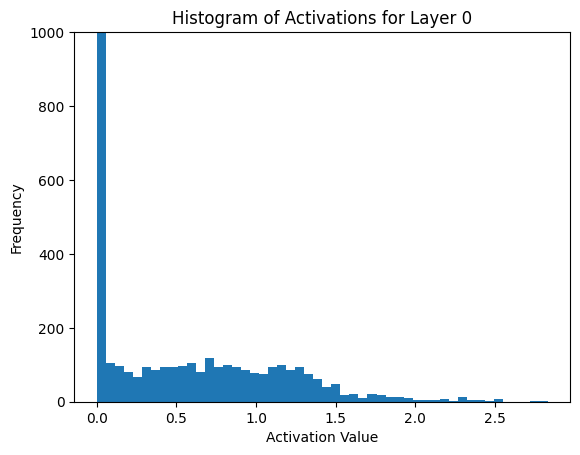

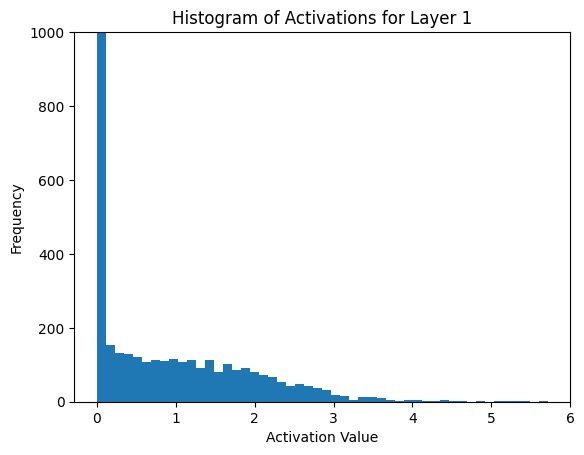

In [7]:
"""
활성화 값 분포도
"""

for layer_index, activation_list in activations.items():
    flattened_activations = [item for sublist in activation_list for item in sublist]
    plt.figure()
    plt.hist(flattened_activations, bins=50)
    plt.title(f'Histogram of Activations for Layer {layer_index}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.ylim([0, 1000])
    plt.show()

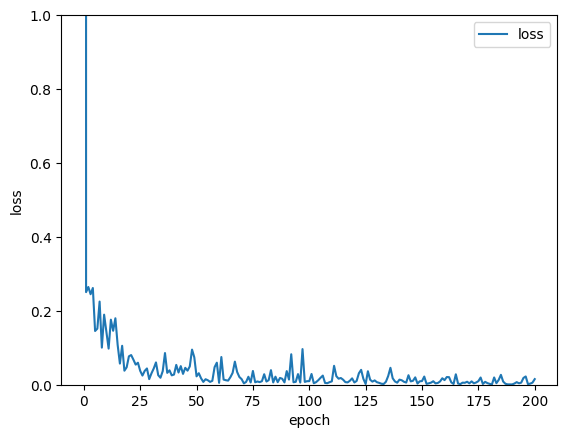

loss_min: 0.0006093540578149259


In [8]:
"""
에폭당 손실값 출력
"""

x = torch.arange(0, epochs + 1, 1)

plt.plot(x, train_loss_list, label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

print("loss_min: " + str(min(train_loss_list)))

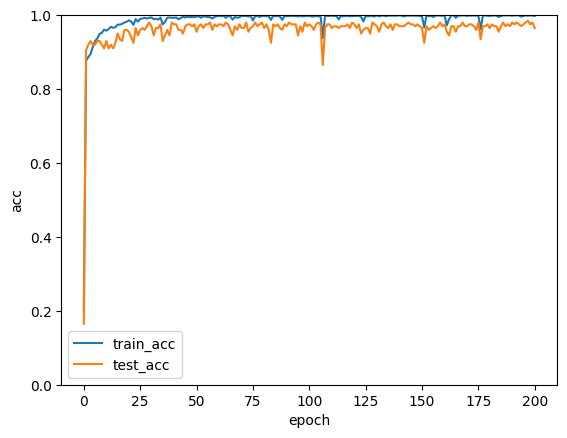

train_acc_max: tensor(0.9993)
test_acc_max: tensor(0.9850)


In [9]:
"""
에폭당 정확도 출력
"""

plt.plot(x, train_acc_list, label="train_acc")
plt.plot(x, test_acc_list, label="test_acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.ylim([0, 1])
plt.legend()
plt.show()

print("train_acc_max: " + str(max(train_acc_list)))
print("test_acc_max: " + str(max(test_acc_list)))

In [10]:
#정확도 계산
model.eval()
y_train = model(x_train)
y_train = torch.round(y_train)
y_test = model(x_test)
y_test = torch.round(y_test)
train_acc = torch.sum(y_train == t_train) / float(x_train.shape[0])
test_acc = torch.sum(y_test == t_test) / float(x_test.shape[0])
print(train_acc)
print(test_acc)

tensor(0.9979)
tensor(0.9650)


In [11]:
#torch.save(model.state_dict(), 'model_state_dict1.pt')